In [44]:
from selenium import webdriver   
from bs4 import BeautifulSoup
from IPython.core.display import HTML
import os
import pandas as pd
import time
from datetime import date
import string
import glob
from IPython.display import Image
from IPython.display import display
import random

Choose the expiration time by using
Dec 2016, Jan 2017 and Feb 2017.

In [2]:
stocks = ['GOOG','YHOO','AAPL','MSFT','AMZN','JPM','BAC','HSBC','CIT','GS']

In [3]:
#12.16; 1.20, 2.17; 
dates = ['1481846400','1484870400','1487289600']
maturity_dates = [date(2016,12,16),date(2017,1,20),date(2017,2,17)]

In [4]:
(date(2016,12,16) - date.today()).days/365

0.1643835616438356

** Example **

In [5]:
url = 'http://finance.yahoo.com/quote/GOOG/options?date=1481846400'
chromedriver = "/Users/Miya/Downloads/chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
driver.get(url)
html_source = driver.page_source
soup = BeautifulSoup(html_source,'html.parser')  
table = soup.findAll('table','calls')
table_html = str(table)
HTML(table_html)

Strike,Contract Name,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
440.00,GOOG161216C00440000,302.80,328.20,331.90,0.00,0.00%,1,4,0.00%
450.00,GOOG161216C00450000,323.00,318.30,322.50,30.10,10.28%,1,4,0.00%
460.00,GOOG161216C00460000,261.00,259.50,263.70,0.00,0.00%,4,6,0.00%
470.00,GOOG161216C00470000,251.10,249.90,253.90,0.00,0.00%,2,7,0.00%
480.00,GOOG161216C00480000,306.00,305.60,308.00,13.20,4.51%,1,35,83.09%
500.00,GOOG161216C00500000,280.10,273.90,277.30,0.00,0.00%,1,9,0.00%
520.00,GOOG161216C00520000,270.90,263.10,266.40,0.00,0.00%,1,4,65.96%
540.00,GOOG161216C00540000,248.77,243.40,247.10,0.00,0.00%,1,9,62.30%
560.00,GOOG161216C00560000,211.70,226.60,230.70,0.00,0.00%,1,46,65.11%
580.00,GOOG161216C00580000,191.20,191.10,192.30,2.40,1.27%,1,104,0.00%


## Crawl All Data

**Option Data on Yahoo Finance is dynamic.(Javascript) Therefore, small tricks are needed when BeautifulSoup is used.**

In [6]:
chromedriver = "/Users/Miya/Downloads/chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
df_dict = {}
today = date.today()
for stock in stocks:
    for date,maturity in zip(dates,maturity_dates):
        ## Get the url
        url = 'http://finance.yahoo.com/quote/'+ stock +'/options?date='+ date
        ## Crawl data
        driver.get(url)
        html_source = driver.page_source 
        ## Beautifulsoup
        soup = BeautifulSoup(html_source,'html.parser')  
        
        if soup.find('table','calls') is not None:
            
            stock_price = [float(i.text) for i in soup.findAll('span','Fz(36px)')]
            title = [i.text for i in soup.find('table','calls').find_all('th')]
            text = [i.text for i in soup.find('table','calls').find_all('td')]
            rows = [row for row in soup.find('table','calls').find_all("tr")]

            l_table = len(rows) - 1
        ## call data 
            dictionary_call = {}
            dictionary_call['maturity_date'] = [maturity]*l_table
            dictionary_call['date'] = [today]*l_table
            dictionary_call['stock_price'] = stock_price * l_table
        
            for j in range(10):
                key = title[j]
                dictionary_call[key] = []
                for i in range(l_table):
                    dictionary_call[key].append(text[10*i+j])
                
                
        ## write into dataframe
            df_call = pd.DataFrame(dictionary_call)
        
        #df.to_csv(stock+date+'.csv')

            if stock not in df_dict.keys():
                df_dict[stock] = df_call
            else:
                df_dict[stock] = pd.concat([df_dict[stock],df_call],ignore_index =  True) 

In [7]:
print('We now have %d dataframes' % len(df_dict.keys()))

We now have 10 dataframes


** Save them into csv **

In [8]:
pwd

"C:\\Users\\Miya\\OneDrive\\Miya'sGithub\\Financial-Modeling"

mkdir data-quiz5

In [9]:
cd data-quiz5

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling\data-quiz5


In [10]:
for key in df_dict.keys():
    name = key + '.csv'
    df_dict[key].to_csv(name)

** Sample DataFrame **

In [11]:
df_dict['AAPL'].columns

Index(['% Change', 'Ask', 'Bid', 'Change', 'Contract Name',
       'Implied Volatility', 'Last Price', 'Open Interest', 'Strike', 'Volume',
       'date', 'maturity_date', 'stock_price'],
      dtype='object')

In [12]:
## no nan
df_dict['AAPL'].isnull().any()

% Change              False
Ask                   False
Bid                   False
Change                False
Contract Name         False
Implied Volatility    False
Last Price            False
Open Interest         False
Strike                False
Volume                False
date                  False
maturity_date         False
stock_price           False
dtype: bool

In [13]:
df_dict['AAPL'].dtypes

% Change               object
Ask                    object
Bid                    object
Change                 object
Contract Name          object
Implied Volatility     object
Last Price             object
Open Interest          object
Strike                 object
Volume                 object
date                   object
maturity_date          object
stock_price           float64
dtype: object

## Problem  One: Implied Volatility Surface

In [14]:
import numpy as np
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

**Implied volatility surface need time to maturity and strike price**

In [15]:
pwd

"C:\\Users\\Miya\\OneDrive\\Miya'sGithub\\Financial-Modeling\\data-quiz5"

In [16]:
cd ../

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling


In [17]:
mkdir implied-volatility-surface

A subdirectory or file implied-volatility-surface already exists.


In [18]:
cd implied-volatility-surface

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling\implied-volatility-surface


### Prepare dataframe

In [19]:
## remove , in dataframe
def remove_punctuation(dataframe):
    columns_to_set = ['Last Price','Open Interest','Strike','Volume']
    for i in columns_to_set:
        series = dataframe[i]
        series_new = []
        for j in series:
            j = str(j)
            j_new = ''.join(ch for ch in j if ch != ',')
            series_new.append(j_new)
        dataframe[i] = series_new
    return dataframe

In [20]:
## change the dtype 
columns_to_change = ['Last Price','Open Interest','Strike','Volume','stock_price']
for key in df_dict.keys():
    dataframe = df_dict[key]
    df_dict[key] = remove_punctuation(dataframe)
    for i in columns_to_change:
        df_dict[key][i] = df_dict[key][i].astype(float)

In [21]:
## check the dtype
df_dict['AAPL'].dtypes 

% Change               object
Ask                    object
Bid                    object
Change                 object
Contract Name          object
Implied Volatility     object
Last Price            float64
Open Interest         float64
Strike                float64
Volume                float64
date                   object
maturity_date          object
stock_price           float64
dtype: object

S, be the price of the stock

V(S,t), the price of a derivative as a function of time and stock price.

C(S,t) the price of a European call option 

K, the strike price of the option.

r, the annualized risk-free interest rate, continuously compounded (the force of interest).

sigma , the standard deviation of the stock's returns; this is the square root of the quadratic variation of the stock's log price process.

t, a time in years; we generally use: now=0, expiry=T.

In [22]:
for key in df_dict.keys():
    time_to_maturity = []
    ## grab dataframe, then relevant data
    for i, j in zip(df_dict[key].maturity_date,df_dict[key].date):
        time_to_maturity.append((i - j).days/365)
        
    strike_price = df_dict[key].Strike
    
    strike_price, time_to_maturity = np.meshgrid(strike_price, time_to_maturity)
    
    # generate pseudo-implied volatility by using strike price and time-to-maturity as parameters
    implied_vol = ((strike_price - 150)**2)/(150 * strike_price)/(np.power(time_to_maturity, 0.95))
    
    fig = plot.figure(figsize = (10,5)) ## a plot object
    ax = Axes3D(fig) # create a 3D object/handle
    
    ##plot surface: array row/column stride(step size:2)
    
    surf = ax.plot_surface(strike_price, time_to_maturity, implied_vol, rstride = 2, cstride = 2, cmap = cm.coolwarm, linewidth = 0.5, antialiased = False)
    #set x,y,a labels
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('time to maturity')
    ax.set_zlabel('implied volatility')
    plot.suptitle(key)
    
    fig.savefig(key+'.png', dpi=fig.dpi)


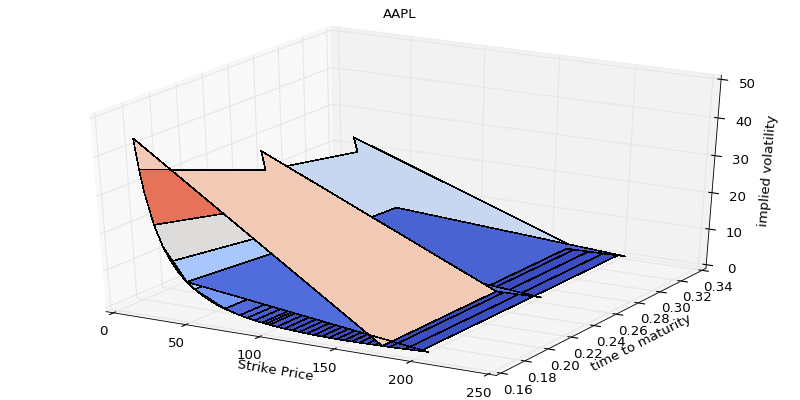

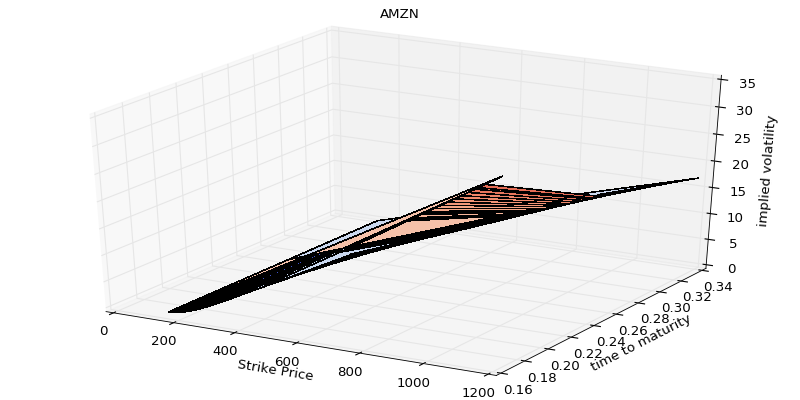

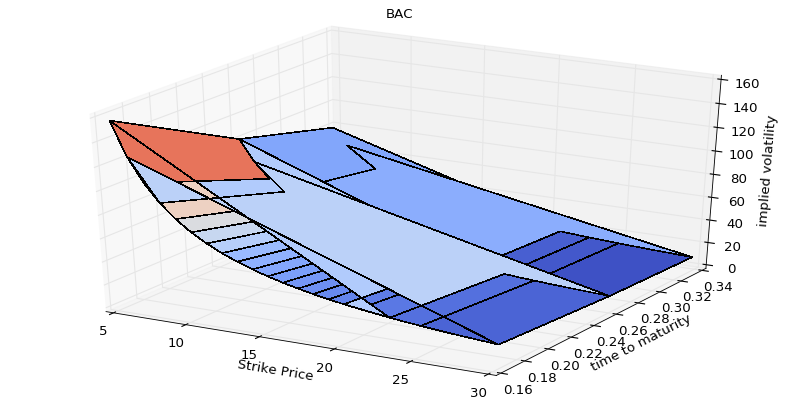

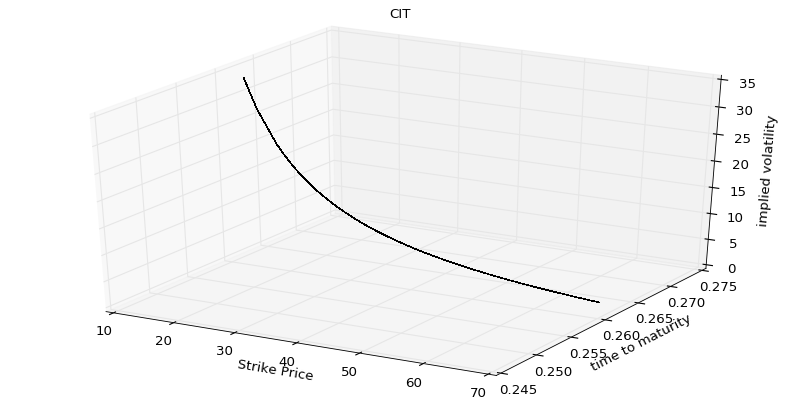

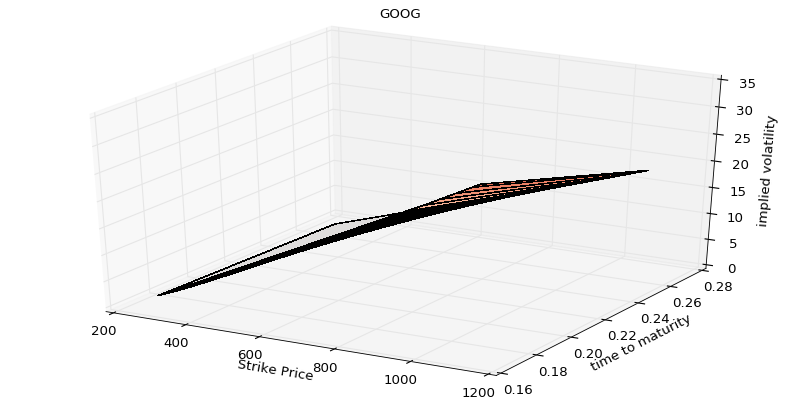

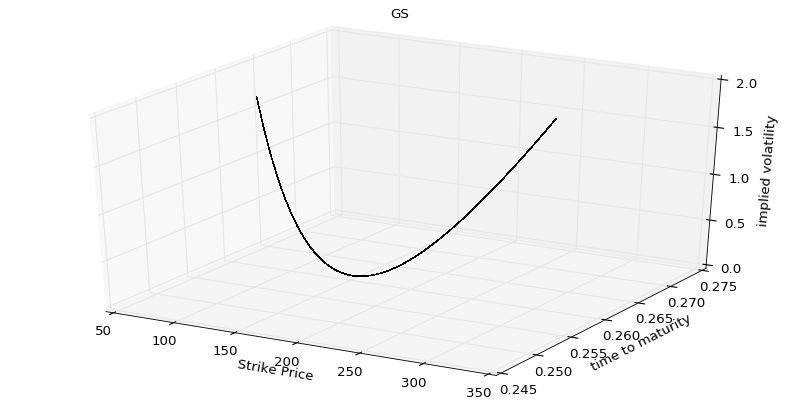

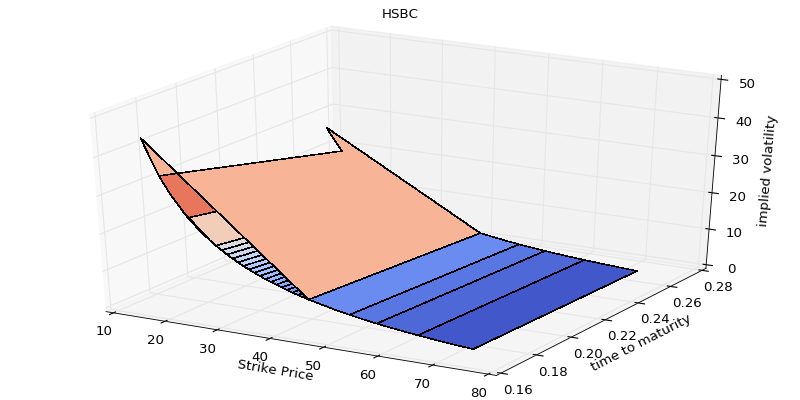

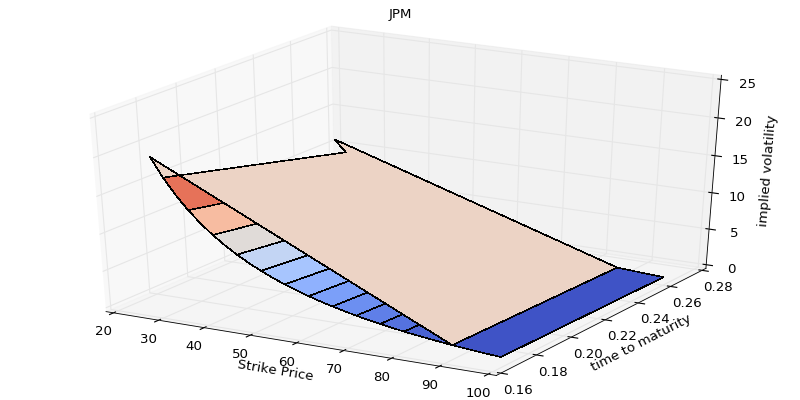

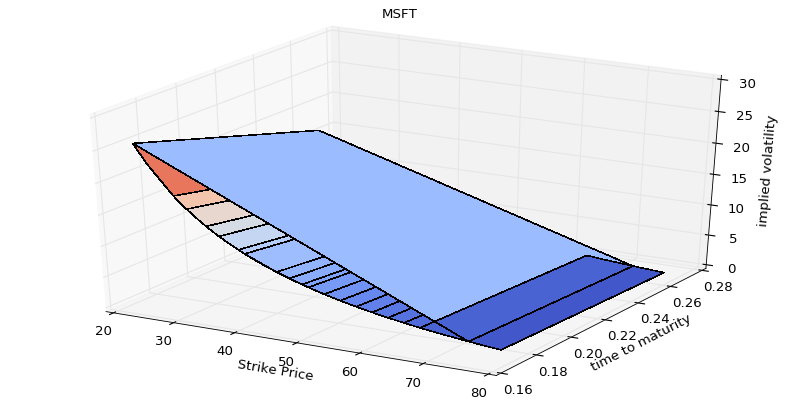

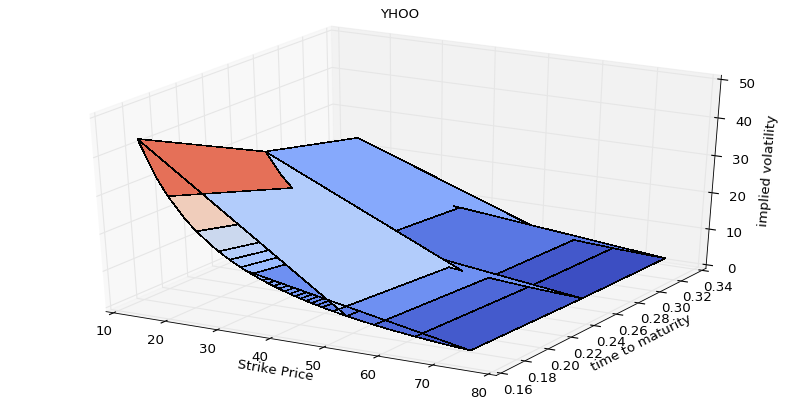

In [23]:
for filename in glob.glob('*'):
    display(Image(filename))

## Estimate Implied Volatitlity

** Classic Bisection method**

** Muller-Bisection method **

** Newton method **


In [24]:
def bsm_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * stats.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [45]:
from scipy import stats
def bs_call_value(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    N_d1 = stats.norm.cdf(d1,0.0,1.0)
    N_d2 = stats.norm.cdf(d2,0.0,1.0)
    
    call_price = (S*N_d1 - K*np.exp(-r * T) * N_d2)
    
    return call_price 

In [74]:
def bs_call_imp_vol_classic(S,K,T,r, C_star, tolerance):    
    
    pred_vol_list = []
        
    sigma_a = random.uniform(0,1)
    sigma_b = random.uniform(0,1)
    
    for (S,K,T,r, C_star) in zip(S,K,T,r, C_star):
        
        n = 0
        
        condition = (bs_call_value(S,K,T,r,sigma_a) - C_star) * (bs_call_value(S,K,T,r,sigma_b) - C_star)
        
        f = abs(bs_call_value(S,K,T,r,(sigma_a+sigma_b)*0.5) - C_star)

        if (f > tolerance and n <2):
            
            while condition > 0:
                sigma_a = random.uniform(0,1)
                sigma_b = random.uniform(0,1)
                condition = (bs_call_value(S,K,T,r,sigma_a) - C_star) * (bs_call_value(S,K,T,r,sigma_b) - C_star)
        
            else:
                sigma_c = (sigma_a+sigma_b)/2
                condition1 = (bs_call_value(S,K,T,r,sigma_a) - C_star) * (bs_call_value(S,K,T,r,sigma_c) - C_star)
                condition2 = (bs_call_value(S,K,T,r,sigma_b) - C_star) * (bs_call_value(S,K,T,r,sigma_c) - C_star)
            
                if condition1 > 0:
                    sigma_b = sigma_b
                    sigma_a = sigma_c
                else:
                    sigma_a = sigma_a
                    sigma_b = sigma_c
                
                condition = (bs_call_value(S,K,T,r,sigma_a) - C_star) * (bs_call_value(S,K,T,r,sigma_b) - C_star)
                f = abs(bs_call_value(S,K,T,r,(sigma_a+sigma_b)*0.5) - C_star)
                
                n = n + 1
        elif (f > tolerance and n >= 2):
            
            pred_vol_list.append('no convergence')
        
        else:
            
            pred_vol = bs_call_value(S,K,T,r,(sigma_a+sigma_b)*0.5)
            
            pred_vol_list.append(pred_vol)
            
    return pred_vol_list

In [ ]:
def bs_call_imp_vol_newton(S,K,T,r, C_star, sigma_est,tolerance):
    
    pred_C = []
    for (S,K,T,r, C_star, sigma_est) in zip(S,K,T,r, C_star, sigma_est):
        
        pred_price = bs_call_value(S,K,T,r,sigma_est)
        f = abs(pred_price- C_star)
        
        while (f > tolerance):
            f_prime = bsm_vega(S,K,T,r,sigma_est)
            sigma_est = sigma_est-(f/f_prime)
            pred_price = bs_call_value(S,K,T,r,sigma_est)
            f = abs(pred_price - C_star)
    
        pred_C.append(pred_price)
        
    return pred_C

In [72]:
def classic_method(tolerance):
    pred_vol_newton = {}
    
    for key in df_dict.keys():
        T = []
    ## grab dataframe, then relevant data
        for i, j in zip(df_dict[key].maturity_date,df_dict[key].date):
            T.append((i - j).days/365)
        
        K  = df_dict[key].Strike
    
        S = df_dict[key].stock_price
# For a standard options pricing model like Black-Scholes, the risk free one-year Treasury rates are used. 
  
        r = np.array([0.02]*len(df_dict[key]))
    
        C_star = df_dict[key]['Last Price'].values
        
        
        vol = bs_call_imp_vol_classic(S,K,T,r, C_star, tolerance)
    
        pred_vol_newton[key] = vol
    return pred_vol_newton

In [27]:
def newton_method(tolerance):
    pred_vol_newton = {}
    
    for key in df_dict.keys():
        T = []
    ## grab dataframe, then relevant data
        for i, j in zip(df_dict[key].maturity_date,df_dict[key].date):
            T.append((i - j).days/365)
        
        K  = df_dict[key].Strike
    
        S = df_dict[key].stock_price
# For a standard options pricing model like Black-Scholes, the risk free one-year Treasury rates are used. 
  
        r = np.array([0.02]*len(df_dict[key]))
    
        C_star = df_dict[key]['Last Price'].values
        
        sigma_est = np.array([0.2]*len(df_dict[key]))
        
        vol = bs_call_imp_vol_newton(S,K,T,r, C_star, sigma_est, tolerance = tolerance)
    
        pred_vol_newton[key] = vol
    return pred_vol_newton

In [59]:
start_time = time.time()
newton = newton_method(tolerance = 0.1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.003852367401123 seconds ---


In [75]:
start_time = time.time()
newton = classic_method(tolerance = 0.1)
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [36]:
import random

In [40]:
random.uniform(0,1)

0.22341585317215418

In [41]:
random.uniform(0,1)

0.5681770772416175